# COVID19 - Brazil States

Install necessary packages for parallel computation:

```
pip install ipyparallel
ipcluster nbextension enable
pip install parallel-execute
```

To install for all users on JupyterHub, as root:
```
jupyter nbextension install --sys-prefix --py ipyparallel
jupyter nbextension enable --sys-prefix --py ipyparallel
jupyter serverextension enable --sys-prefix --py ipyparallel
```

start cluster at jupyter notebook interface

In [1]:
import urllib.request
import pandas as pd
import numpy as np

# Download data

In [2]:
import get_data
LoadData=False

if LoadData:
    get_data.get_data()

In [3]:
df = pd.read_csv("data/dados_total_estados.csv")
df

,index,date,state,city,place_type,confirmed,deaths,order_for_place,is_last,popEst,city_ibge_code,confirmed_per_100k_inhabitants,death_rate
0,0,2020-06-06,SE,TOTAL,state,8972,208,74,True,2298696.0,28.0,390.30824,0.0232
1,1,2020-06-05,SE,TOTAL,state,8577,198,73,False,2298696.0,28.0,373.12459,0.0231
2,2,2020-06-04,SE,TOTAL,state,8200,186,72,False,2298696.0,28.0,356.72399,0.0227
3,3,2020-06-03,SE,TOTAL,state,7989,180,71,False,2298696.0,28.0,347.54487,0.0225
4,4,2020-06-02,SE,TOTAL,state,7555,172,70,False,2298696.0,28.0,328.66460,0.0228
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2244,158210,2020-03-11,BA,TOTAL,state,3,0,5,False,14873064.0,29.0,0.02017,0.0000
2245,158211,2020-03-10,BA,TOTAL,state,2,0,4,False,14873064.0,29.0,0.01345,0.0000
2246,158212,2020-03-09,BA,TOTAL,state,2,0,3,False,14873064.0,29.0,0.01345,0.0000
2247,158213,2020-03-07,BA,TOTAL,state,2,0,2,False,14873064.0,29.0,0.01345,0.0000


# Model

In [4]:
states=['SP','ES','MG','RJ','PE','CE','AM']
# states=['MG','ES','SP']
states

['SP', 'ES', 'MG', 'RJ', 'PE', 'CE', 'AM']

# SEAIR-D Model Equations

$$\begin{array}{l}\frac{d s}{d t}=-[\beta i(t) + \beta_2 a(t)-\mu] \cdot s(t)\\ 
\frac{d e}{d t}=[\beta i(t) + \beta_2 a(t)] \cdot s(t) -(\sigma+\mu) \cdot e(t)\\ 
\frac{d a}{d t}=\sigma e(t) \cdot (1-p)-(\gamma_2+\mu) \cdot a(t) \\
\frac{d i}{d t}=\sigma e(t) \cdot p - (\gamma + \sigma_2 + \sigma_3 + \mu) \cdot i(t)\\ 
\frac{d r}{d t}=(b + \sigma_2) \cdot i(t) + d \cdot a(t) - \mu \cdot r(t)\\
\frac{d k}{d t}=(a + \sigma_3 - \mu) \cdot d(t) + c \cdot a(t)
\end{array}$$

The last equation does not need to be solve because:

$$\frac{d k}{d t}=-(\frac{d e}{d t}+\frac{d a}{d t}+\frac{d i}{d t}+\frac{d r}{d t})$$

The sum of all rates are equal to zero! The importance of this equation is that it conservates the rates.

$$\gamma = a + b$$

$$\gamma_2 = c + d$$

$$p=0.2$$

## Parameters

$\beta$: Effective contact rate [1/min]
    
$\gamma$: from infected Recovery(+Mortality) rate $\gamma=(a+b)$ [1/min]

$\gamma_2$: from assymptomatic Recovery(+Mortality) rate $\gamma=(a+b)$ [1/min]

$a$: mortality of healed  [1/min]

$b$: recovery rate  [1/min]

$\sigma$: is the rate at which individuals move from the exposed to the infectious classes. Its reciprocal ($1/\sigma$) is the average latent (exposed) period.

$\sigma_2$: is the rate at which individuals move from the infectious to the healed classes. Its reciprocal ($1/\sigma_2$) is the average latent (exposed) period

$\sigma_3$: is the rate at which individuals move from the infectious to the dead classes. Its reciprocal ($1/\sigma_3$) is the average latent (exposed) period
    
$p$: is the fraction of the exposed which become symptomatic infectious sub-population.

$(1-p)$: is the fraction of the exposed which becomes asymptomatic infectious sub-population.

# Initial parameters

In [5]:
paramOpt=2

if paramOpt==1:
    paramFile="data/param_optimized_DE SciPyHistMin.csv"

if paramOpt==2:
    paramFile="data/param_optimized_YaboxHistMin.csv"

if paramOpt==3:
    paramFile="data/param.csv"

dfparam = pd.read_csv(paramFile)
dfparam = dfparam.dropna()
dfparam

,state,start-date,prediction-range,s0,e0,a0,i0,r0,d0,START,RATIO,WCASES,WREC
0,SP,2020-03-15,200,8.387120e+06,0,0,856,300,250,100,0.15,0.632506,0.001361
1,ES,2020-04-01,200,5.545072e+05,0,0,56,250,50,100,0.15,0.302163,0.043954
2,MG,2020-04-01,200,1.315470e+06,0,0,239,250,40,100,0.15,0.482943,0.013289
3,RJ,2020-03-20,200,8.269243e+05,0,0,843,250,50,100,0.15,0.471485,0.011113
4,CE,2020-03-20,200,6.761164e+05,0,0,905,250,50,100,0.15,0.404860,0.047382
5,PE,2020-03-20,200,8.077560e+05,0,0,718,250,100,100,0.15,0.516546,0.034770
6,AM,2020-03-20,200,6.052322e+05,0,0,716,250,100,100,0.15,0.393127,0.022712


# Initial parameter optimization

In [6]:
import ray
ncpu=len(states)
ray.init(num_cpus=ncpu)

# Load solver
%reload_ext autoreload
%autoreload 2
import LearnerYabox_v2b as Learner #Yabox

2020-06-14 09:26:03,297	INFO resource_spec.py:212 -- Starting Ray with 154.1 GiB memory available for workers and up to 70.04 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-06-14 09:26:03,646	INFO services.py:1170 -- View the Ray dashboard at localhost:8267
2020-06-14 09:26:04,587	INFO resource_spec.py:212 -- Starting Ray with 154.0 GiB memory available for workers and up to 70.0 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-06-14 09:26:04,704	WARNING services.py:928 -- Redis failed to start, retrying now.
2020-06-14 09:26:05,001	INFO services.py:1170 -- View the Ray dashboard at localhost:8267


In [7]:
allStates=True
cleanRecovered=False
version="7"

results=[]
if allStates:
    for state in states:        
        query = dfparam.query('state == "{}"'.format(state)).reset_index()
        parameters = np.array(query.iloc[:, 2:])[0]
        parameters
        
        f=Learner.Learner.remote(state, *parameters, cleanRecovered, version)
        result = f.train.remote() 
        results.append(result)
else:
    state= "SP"
    query = dfparam.query('state == "{}"'.format(state)).reset_index()
    parameters = np.array(query.iloc[:, 2:])[0]
    parameters
    cleanRecovered = False
    f=Learner.Learner.remote(state, *parameters, cleanRecovered, version)
    result = f.train.remote() 
    results.append(result)

# #execute all the queue with max_runner_cap at a time    
results = ray.get(results)

(pid=147644) /home/ats4i/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
(pid=147644)   warnings.warn(warning_msg, ODEintWarning)
(pid=147642) /home/ats4i/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
(pid=147642)   warnings.warn(warning_msg, ODEintWarning)
(pid=147647) /home/ats4i/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
(pid=147647)   warnings.warn(warning_msg, ODEintWarning)
(pid=147634) /home/ats4i/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong

In [8]:
ray.shutdown()

# Plots

In [9]:
%matplotlib inline 
import matplotlib.pyplot as plt
import pandas as pd
#%load_ext autoreload
%reload_ext autoreload
%autoreload 2
import covid_plots

In [10]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines){
    return false;}

<IPython.core.display.Javascript object>

In [11]:
#select districts for plotting log plot
states4Plot=['MG',
               'SP',
               'ES',
               'CE',
               'RJ']

#Choose here your options
#opt=0 all plots
#opt=1 corona log plot
#opt=2 logistic model prediction
#opt=3 bar plot with growth rate
#opt=4 log plot + bar plot
#opt=5 SEAIR-D Model
opt = 5

#versio'n to identify the png file result
version = "7"

#number of cases to start plotting model in log graph - real data = 100
startCase=100

/home/ats4i/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


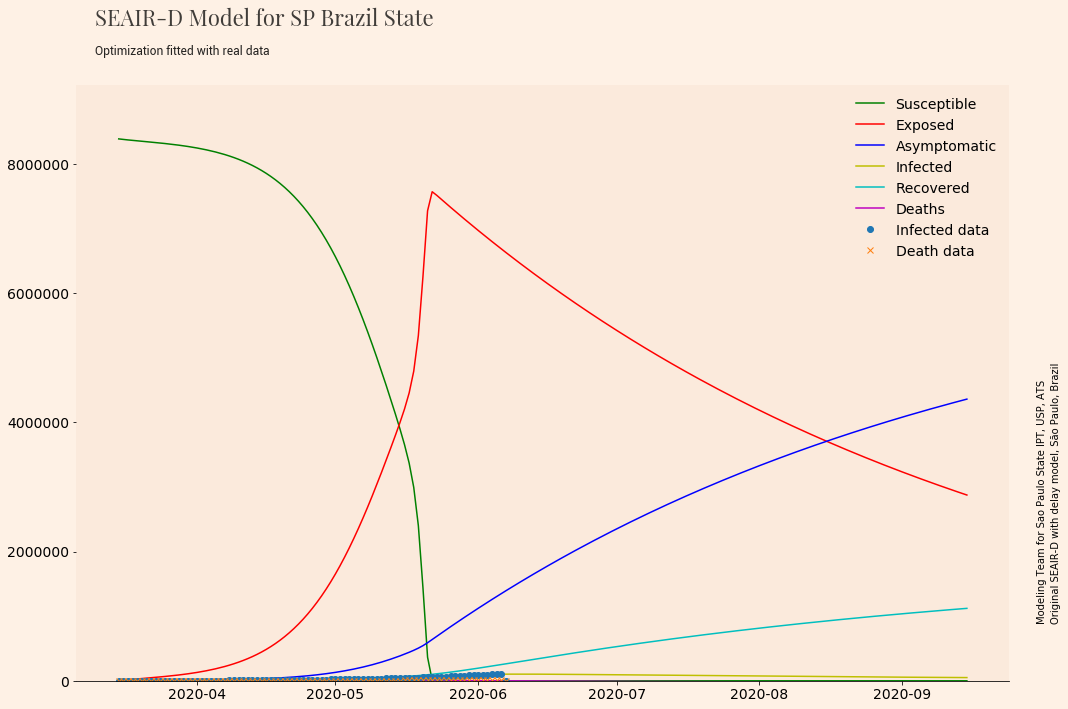

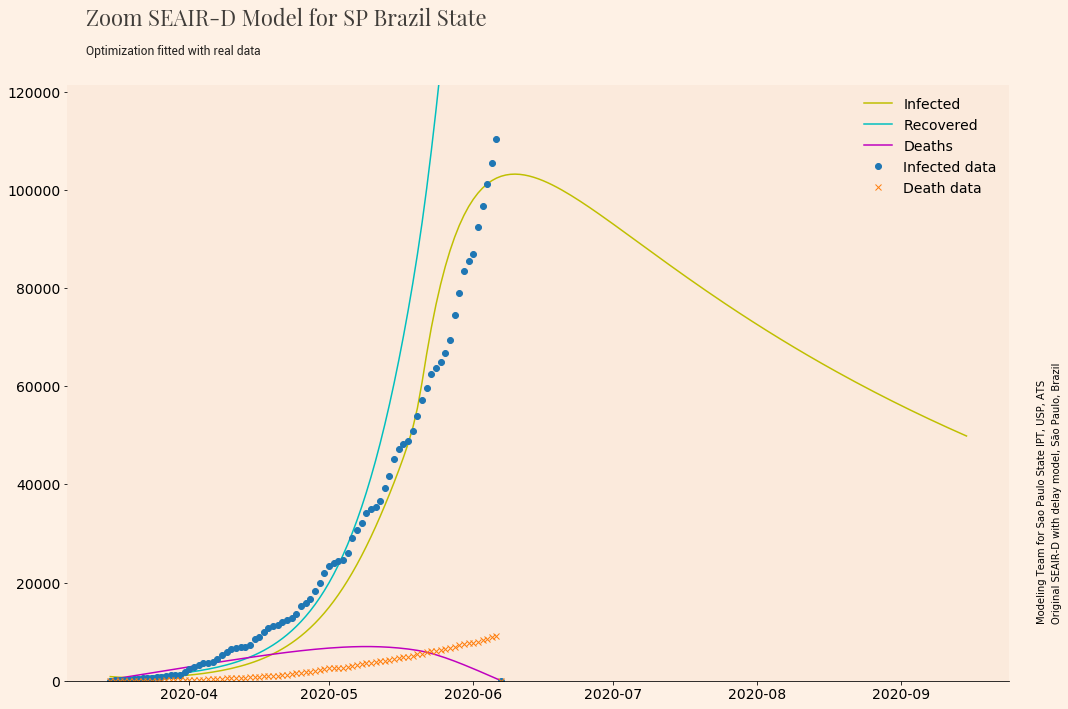

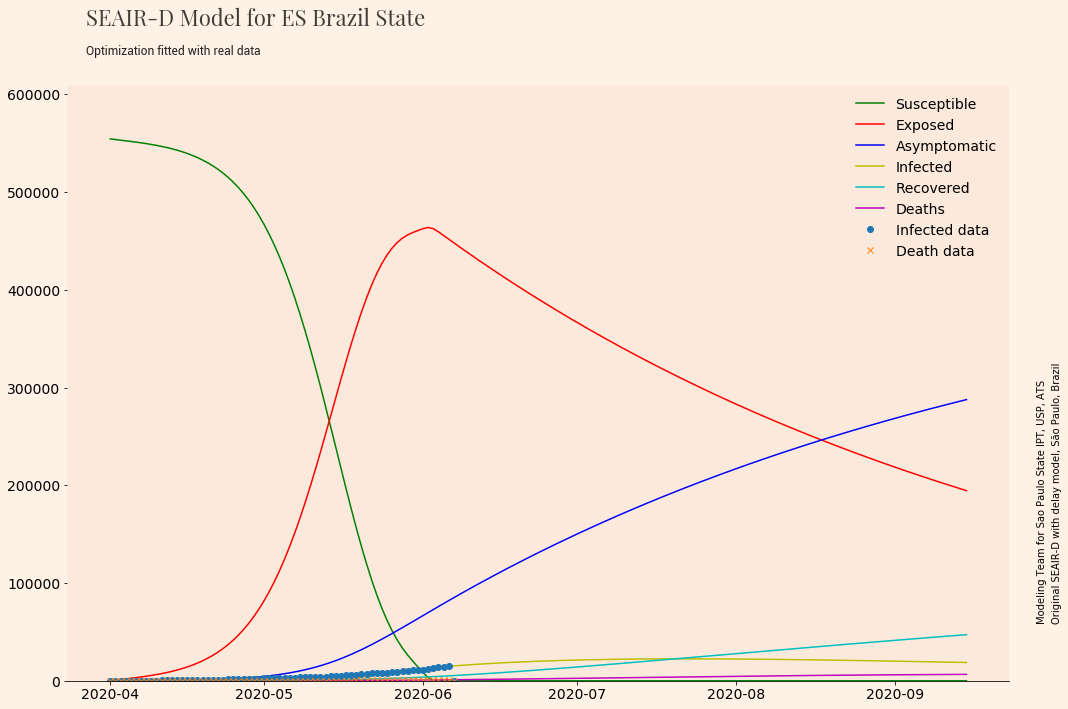

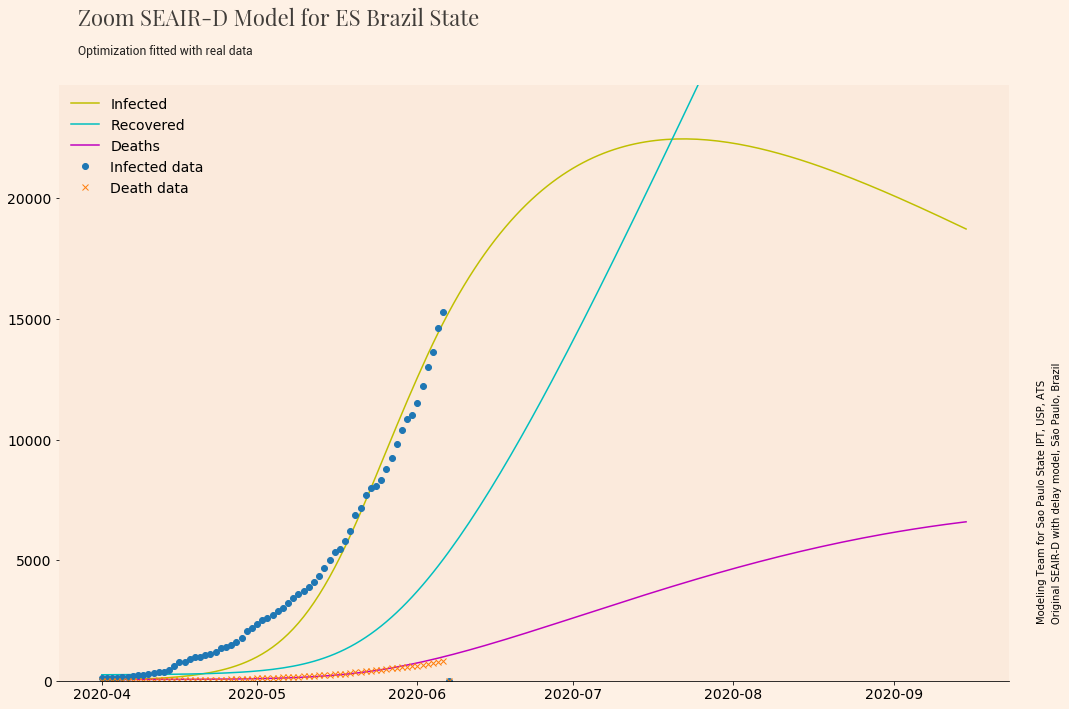

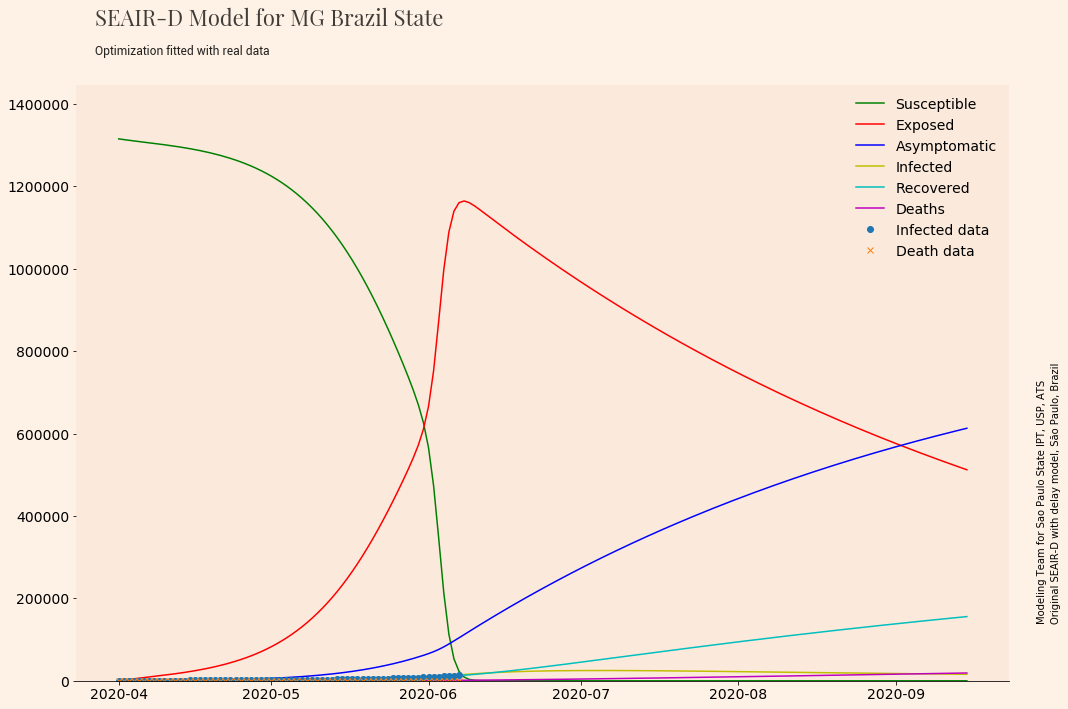

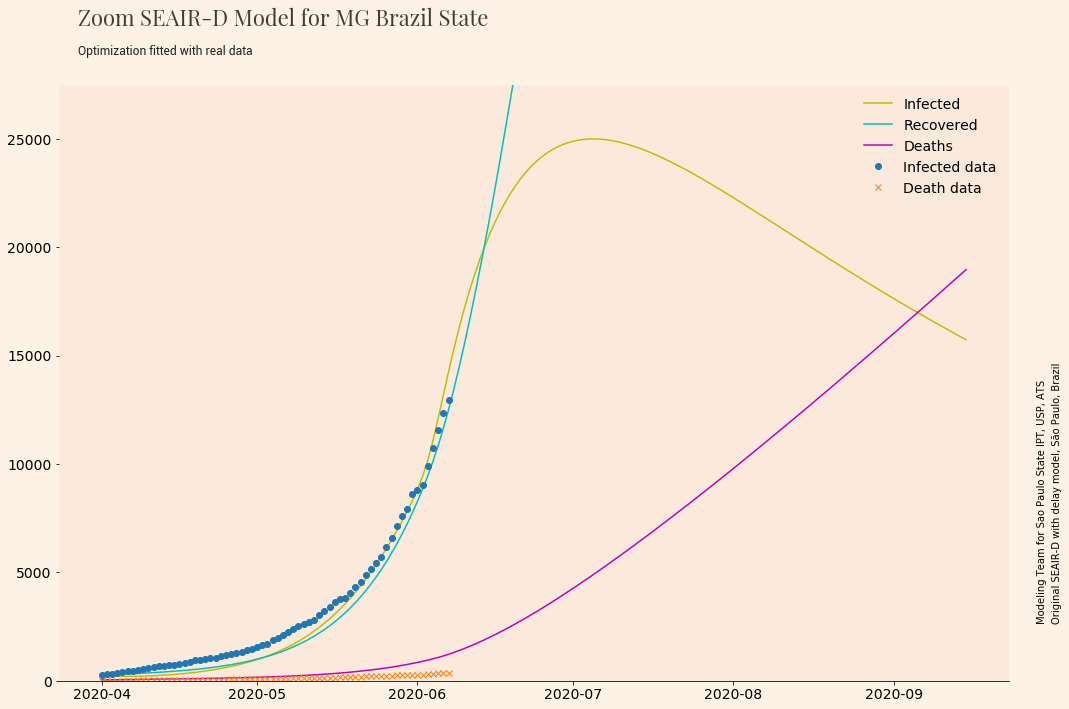

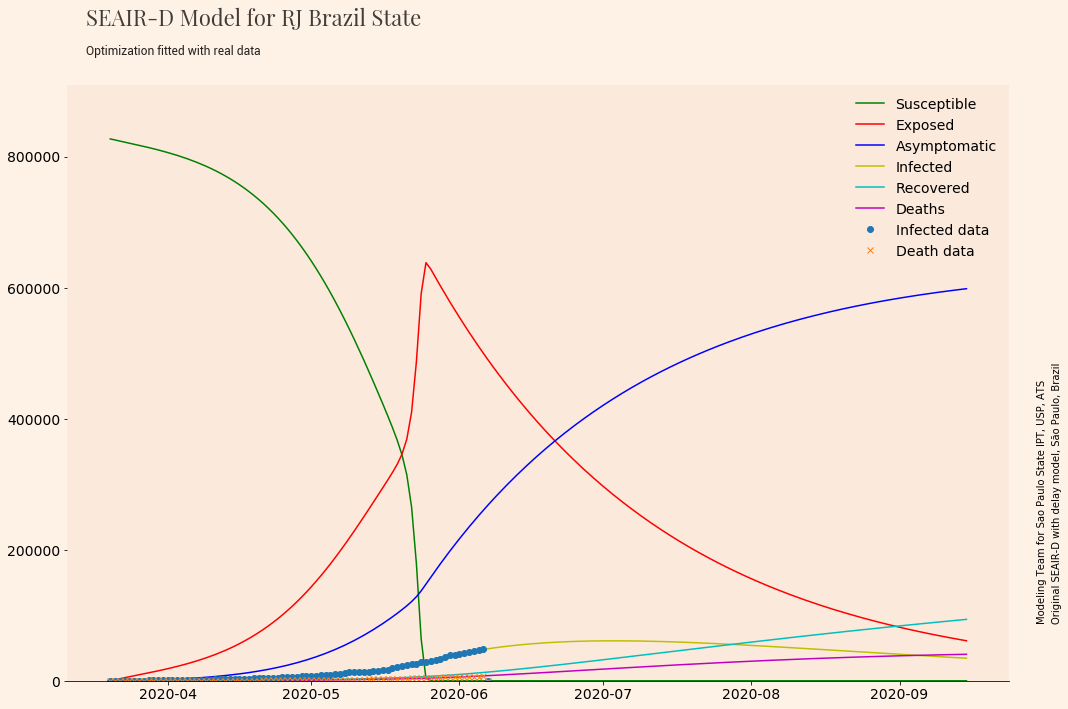

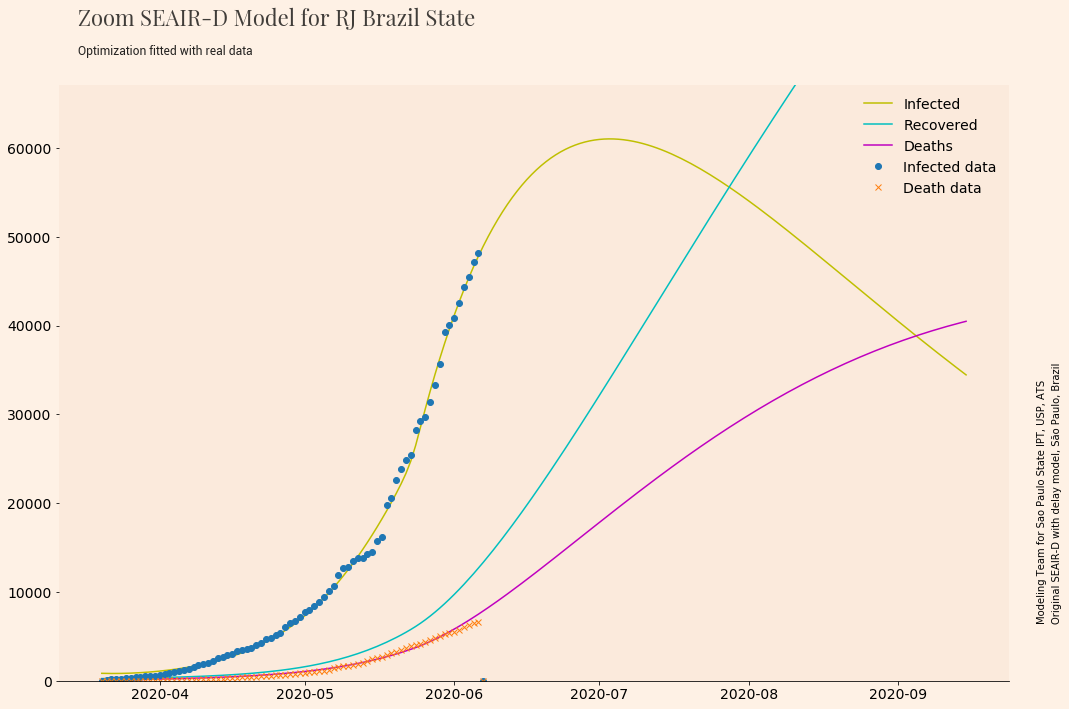

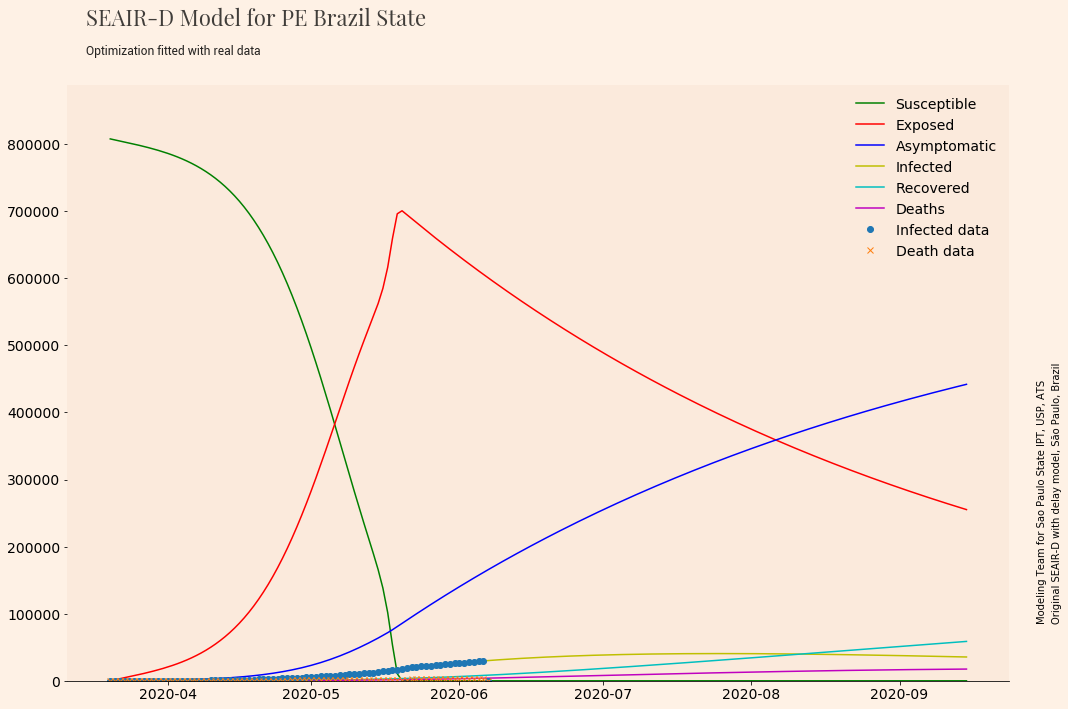

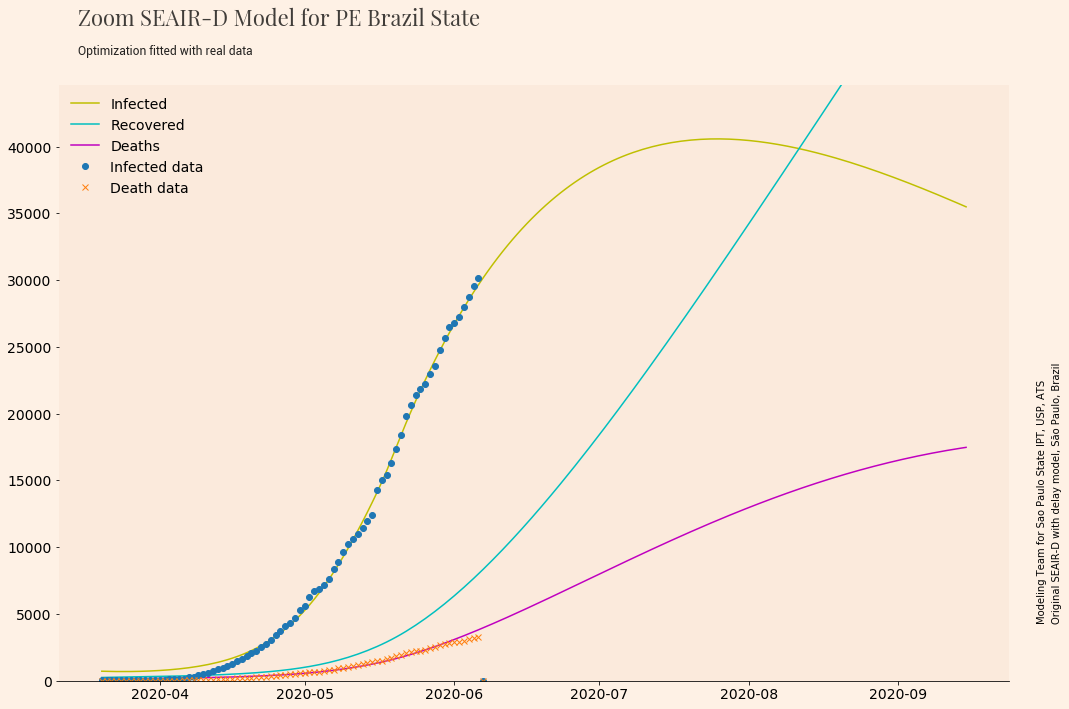

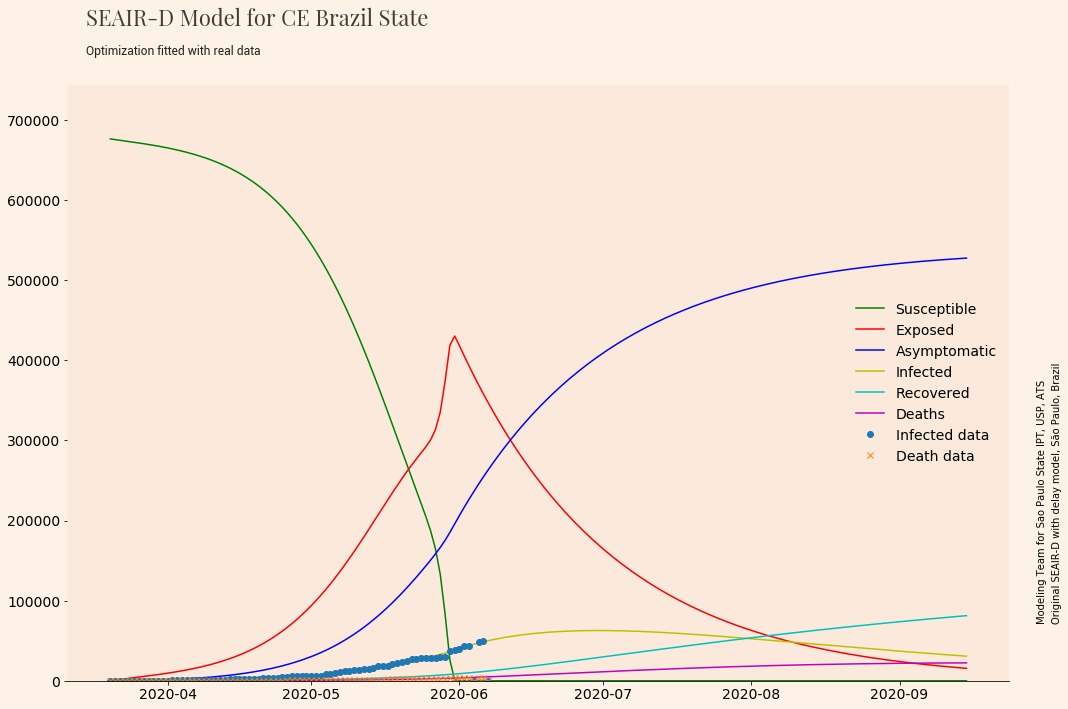

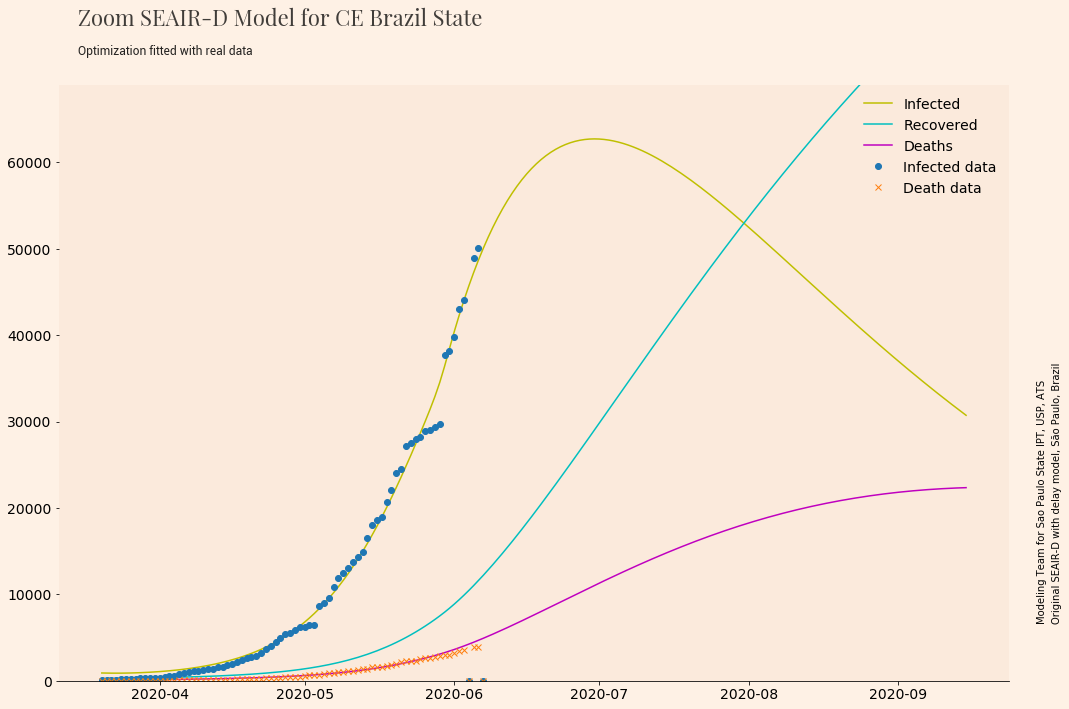

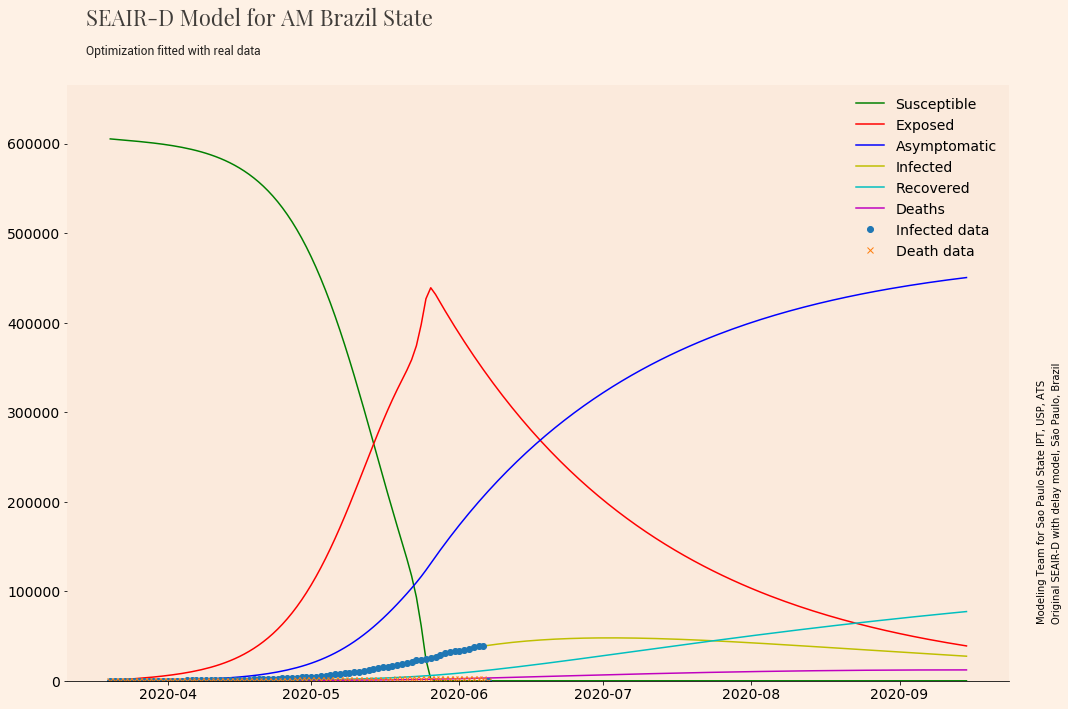

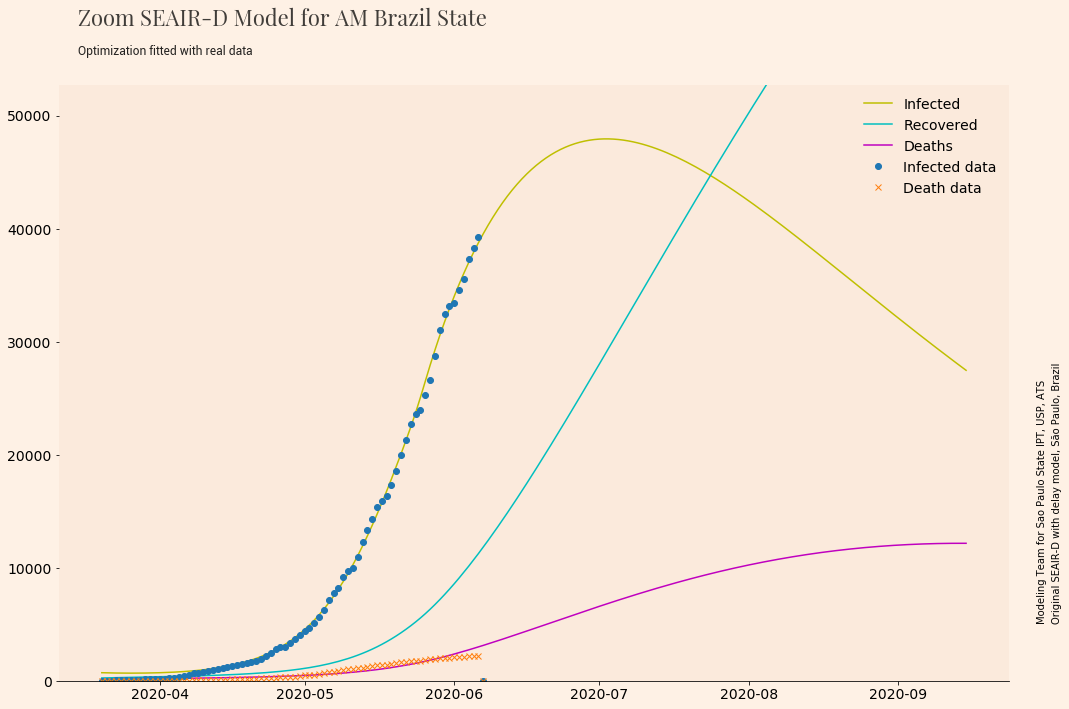

In [12]:
#plots one district or all districts
from datetime import datetime,timedelta
dfparam = pd.read_csv(paramFile)
plotStates=True

#select states for plotting
#you need to run (solve) it before plotting
if plotStates:
    states=['SP','ES','MG','RJ','PE','CE','AM']
    allStates=True

#main state for plotting log graph or SEAIRD plot
state="ES"

#if it is not SEAIRD plot, so plot one state only
if not opt==5:
    AllStates=False

if allStates:
    for state in states:
        query = dfparam.query('state == "{}"'.format(state)).reset_index()
        ratio = query['RATIO'][0]
        startCase = query['START'][0]
        startdate = query['start-date'][0]
        predict_range = query['prediction-range'][0]
        
        #calcula data máxima dos gráficos
        #100 dias é usado como máximo dos cálculos da derivada das mortes
        lastDate=df.date.max()
        maxDate= datetime.strptime(lastDate, '%Y-%m-%d') + timedelta(days = 100) #"2020-08-31"
        maxDateStr = maxDate.strftime("%Y-%m-%d")

        covid_plots.covid_plots(state, states4Plot, startdate, predict_range, \
                        startCase, 5, version, show=True, ratio=ratio, maxDate=maxDateStr)
else: 
    query = dfparam.query('state == "{}"'.format(state)).reset_index()
    ratio = query['RATIO'][0]
    startdate = query['start-date'][0]
    predict_range = query['prediction-range'][0]
    startCase = query['START'][0]
    
    #calcula data máxima dos gráficos
    #100 dias é usado como máximo dos cálculos da derivada das mortes
    lastDate=df.date.max()
    maxDate= datetime.strptime(lastDate, '%Y-%m-%d') + timedelta(days = 100) #"2020-08-31"
    maxDateStr = maxDate.strftime("%Y-%m-%d")    
    
    covid_plots.covid_plots(state, states4Plot, startdate,predict_range, \
                       startCase, opt, version, show=True, ratio=ratio, maxDate=maxDateStr)